In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
plt.rcParams['figure.figsize'] = [10, 6]

K = 6 #number of stages in binomial bridge
assert(K%2 == 0)
N = 1000 #number of steps
num_simulations = 100 #number of simulations for averaging

In [2]:
#create binomial bridge with K stages
def createBinomialBridge(mu_dict=None, sigma2_dict=None):
    G = nx.grid_2d_graph(K//2 + 1, K//2 + 1, create_using=nx.DiGraph)
    #remove edges in wrong direction
    G.remove_edges_from([edge for edge in nx.edges(G) if edge[0][0] > edge[1][0] or edge[0][1] > edge[1][1]])
    
    if mu_dict is None and sigma2_dict is None:
        mu_dict = {edge : -0.5 for edge in G.edges()}
        sigma2_dict = {edge : 1 for edge in G.edges()}
    
    nx.set_edge_attributes(G, mu_dict, "mu")
    nx.set_edge_attributes(G, sigma2_dict, "sigma2")
    
    theta_dict = {edge : round(np.random.lognormal(mu_dict[edge], sigma2_dict[edge]), 3) for edge in G.edges()}
    nx.set_edge_attributes(G, theta_dict, "theta")
    
    return G

In [3]:
def plotBinomialBridge(G):
    pos = {(x,y):(x+y,x-y) for x,y in G.nodes()}

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=300)

    # edges
    nx.draw_networkx_edges(G, pos, arrows=True)
    SP_nodes = nx.shortest_path(G, (0,0), (K//2,K//2), weight="theta") #Nodes in shortest path
    SP_edges = [(SP_nodes[i], SP_nodes[i+1]) for i in range(K)] #Edges in shortest path
    nx.draw_networkx_edges(G, pos, edgelist=SP_edges, edge_color='red', arrows=True)
    
    # node labels
    nx.draw_networkx_labels(G, pos, font_size=7)

    # edge weight labels
    weights = nx.get_edge_attributes(G, "theta")
    nx.draw_networkx_edge_labels(G, pos, weights)

In [4]:
def sample_travel_times(G, edges, sigma2_tilde):
    theta = nx.get_edge_attributes(G, "theta")
    return {edge : np.random.lognormal(np.log(theta[edge]) - sigma2_tilde/2, sigma2_tilde) for edge in edges}

In [5]:
def Epsilon_Greedy(G, epsilon, mu_0=-0.5, sigma2_0=1):
    sigma2_tilde=1
    mu_dict = {edge : mu_0 for edge in nx.edges(G)}
    sigma2_dict = {edge : sigma2_0 for edge in nx.edges(G)}
    chosen_paths = []
    for t in range(N):
        if np.random.random() < epsilon:
            all_paths=[]
            for path in nx.all_simple_paths(G, (0,0), (K//2,K//2)):
                all_paths.append(path)
            chosen_paths.append(all_paths[np.random.randint(len(all_paths))])
        else:
            G_sampled = createBinomialBridge()
            theta_dict = {edge : round(np.exp(mu_dict[edge] + sigma2_dict[edge]/2), 3) for edge in G.edges()}
            nx.set_edge_attributes(G_sampled, theta_dict, "theta")

            chosen_paths.append(nx.shortest_path(G_sampled, (0,0), (K//2,K//2), weight="theta"))
        
        chosen_path_edges = [(chosen_paths[-1][i], chosen_paths[-1][i+1]) for i in range(K)] #edges in sampled path
        
        sampled_travel_time = sample_travel_times(G, chosen_path_edges, sigma2_tilde)        
        
        for edge in chosen_path_edges:
            mu_dict[edge] = (mu_dict[edge]/sigma2_dict[edge] + (1/sigma2_tilde) * (np.log(sampled_travel_time[edge]) + sigma2_tilde/2)) / (1/sigma2_dict[edge] + 1/sigma2_tilde)
            sigma2_dict[edge] = 1 / (1/sigma2_dict[edge] + 1/sigma2_tilde)
    
    return chosen_paths

In [6]:
def Thompson_Sampling(G, mu_0=-0.5, sigma2_0=1):
    sigma2_tilde=1
    mu_dict = {edge : mu_0 for edge in nx.edges(G)}
    sigma2_dict = {edge : sigma2_0 for edge in nx.edges(G)}
    chosen_paths = []
    for t in range(N):
        G_sampled = createBinomialBridge(mu_dict, sigma2_dict)
        chosen_paths.append(nx.shortest_path(G_sampled, (0,0), (K//2,K//2), weight="theta"))
        
        SP_edges = [(chosen_paths[-1][i], chosen_paths[-1][i+1]) for i in range(K)] #edges in sampled shortest path
        
        sampled_travel_time = sample_travel_times(G, SP_edges, sigma2_tilde)        
        
        for edge in SP_edges:
            mu_dict[edge] = (mu_dict[edge]/sigma2_dict[edge] + (1/sigma2_tilde) * (np.log(sampled_travel_time[edge]) + sigma2_tilde/2)) / (1/sigma2_dict[edge] + 1/sigma2_tilde)
            sigma2_dict[edge] = 1 / (1/sigma2_dict[edge] + 1/sigma2_tilde)
    
    return chosen_paths

In [7]:
def per_period_regret(G, chosen_paths):
    regret = np.zeros(len(chosen_paths))
    for i in range(len(chosen_paths)):
        regret[i] = nx.path_weight(G, chosen_paths[i], "theta") - nx.shortest_path_length(G, (0,0), (K//2,K//2), weight="theta")
    return [np.mean(regret[:i+1]) for i in range(len(chosen_paths))]

In [8]:
def plot_regrets(alg_paths_dict, G):
    fig, ax = plt.subplots()
    
    for algorithm in alg_paths_dict:
        ax.plot(range(N), per_period_regret(G, alg_paths_dict[algorithm]), label=algorithm)
    
    ax.legend()
    ax.set_title('per-period regret')
    ax.set_xlabel('time period')
    ax.set_ylabel(None)

    plt.show()

Red edges are the shortest path from Start=(0,0) to End=(3, 3)
Wall time: 668 ms


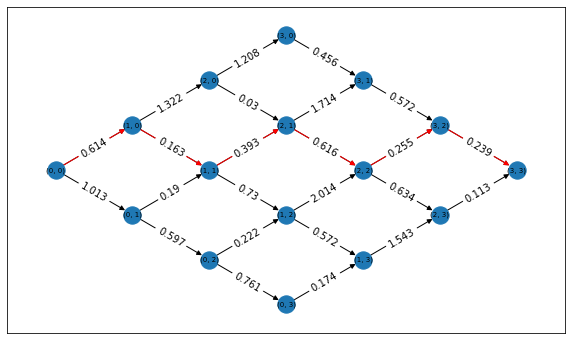

In [9]:
%%time
G = createBinomialBridge()
plotBinomialBridge(G)
print(f'Red edges are the shortest path from Start=(0,0) to End=({K//2}, {K//2})')

EG_paths = Epsilon_Greedy(G, 0)
TS_paths = Thompson_Sampling(G)

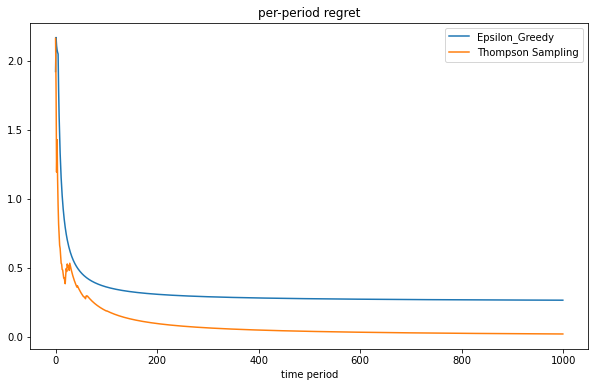

In [10]:
alg_paths_dict = {'Epsilon_Greedy' : EG_paths,
                  'Thompson Sampling' : TS_paths}

plot_regrets(alg_paths_dict, G)

In [11]:
#plot per-period regret (average over many simulations)
def plot_avg_per_period_regret(alg_regret_dict):
    fig, ax = plt.subplots()
    
    for algorithm in alg_regret_dict:
        ax.plot(range(N), np.mean(alg_regret_dict[algorithm], axis=0), label=algorithm)

    ax.legend()
    ax.set_title(f'average per-period regret over {num_simulations} simulations')
    ax.set_xlabel('time period')
    ax.set_ylabel(None)

    plt.show()

In [12]:
#simulate a bunch of algorithms
def simulate(algorithms, params, num_simulations=num_simulations):
    paths = []
    avg_per_period_regret = []
    names = []
    for j in range(len(algorithms)):
        paths.append([])
        avg_per_period_regret.append([])
        
    for i in range(num_simulations):
        G = createBinomialBridge()
        
        for j in range(len(algorithms)):
            if algorithms[j] == 'Epsilon_Greedy':
                paths[j].append(Epsilon_Greedy(G, epsilon=params[j][0], mu_0=params[j][1], sigma2_0=params[j][2]))
                names.append(f'{params[j][0]}-greedy with mu={params[j][1]} and sigma^2={params[j][2]}')
            elif algorithms[j] == 'Thompson_Sampling':
                paths[j].append(Thompson_Sampling(G, mu_0=params[j][0], sigma2_0=params[j][1]))
                names.append(f'Thompson Sampling with mu={params[j][0]} and sigma^2={params[j][1]}')
            avg_per_period_regret[j].append(per_period_regret(G, paths[j][i])) 
    
    alg_regret_dict = {names[j] : avg_per_period_regret[j] for j in range(len(algorithms))}
    return alg_regret_dict

*simulate()* inputs have following form:

*algorithms = [alg_1, alg_2, alg_3, ..., alg_n]*, where *alg_i* is *'Epsilon_Greedy'*, *'Annealing_Epsilon_Greedy'* or *'Thompson_Sampling'*.

*params = [[x_1, a_1, b_1], [x_1, a_2, b_2], [x_3, a_3, b_3], ..., [x_n, a_n, b_n]]*, where *a_i* is alpha of prior distribution, *b_i* is beta of prior distribution, and *x_i* is hyperparameter of corresponding algorithm (*epsilon* for *'Epsilon_Greedy'*, *m* for *'Annealing_Epsilon_Greedy'* or nothing for *'Thompson_Sampling'*).

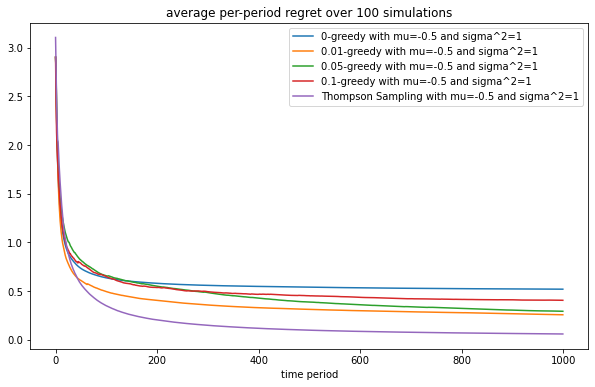

Wall time: 3min 11s


In [13]:
%%time
alg_regret_dict = simulate(['Epsilon_Greedy', 'Epsilon_Greedy', 'Epsilon_Greedy', 'Epsilon_Greedy', 'Thompson_Sampling'],
                           [[0, -0.5,1], [0.01, -0.5,1], [0.05, -0.5,1], [0.1, -0.5,1], [-0.5,1]],
                           num_simulations=100)
plot_avg_per_period_regret(alg_regret_dict)